In [11]:
from datetime import datetime, timedelta
import pandas
from data_cache import pandas_cache
import binance
import numpy

COUNT_YEARS = 10
BINANCE_DATETIME_FORMAT = "%Y-%m-%d %H-%M-%S"

SYMBOL = 'ETHUSDT'
CURRENT_PRICE = 1987.
WINDOW_PERIOD = 48

@pandas_cache("code", "year")
def load_prices(client: binance.Client, code: str, year: int):
    from_date = datetime(year, 1, 1, 0, 0, 0)
    until_date = datetime(year + 1, 1, 1, 0, 0, 0) - timedelta(seconds=1)

    # Execute the query from binance - timestamps must be converted to strings !
    candles = client.get_historical_klines(code, binance.Client.KLINE_INTERVAL_1HOUR, str(from_date), str(until_date))

    # Create a dataframe to label all the columns returned by binance so we work with them later.
    df = pandas.DataFrame(candles, columns=['dateTime', 'open', 'high', 'low', 'close', 'volume', 'closeTime',
                                           'quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol', 'takerBuyQuoteVol',
                                           'ignore'])

    # as timestamp is returned in ms, let us convert this back to proper timestamps.
    df['open'] = df['open'].astype(float)
    df['high'] = df['high'].astype(float)
    df['low'] = df['low'].astype(float)
    df['close'] = df['close'].astype(float)
    df['volume'] = df['volume'].astype(float)
    df.dateTime = pandas.to_datetime(df.dateTime, unit='ms')
    df.set_index('dateTime', inplace=True)
    return df


# Create a client object
client = binance.Client()

current_year = datetime.now().year
df_years = list()
for year in range(current_year - COUNT_YEARS, current_year + 1):
    df = load_prices(client, SYMBOL, year)
    df = df.drop(['closeTime', 'quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol', 'takerBuyQuoteVol', 'ignore'], axis=1)
    df_years.append(df)

prices_df = pandas.concat(df_years, axis=0)
prices_df.index = pandas.to_datetime(prices_df.index)

daily_prices = prices_df.groupby(prices_df.index.date)['open'].first()

**Draw-down probability**

<AxesSubplot: >

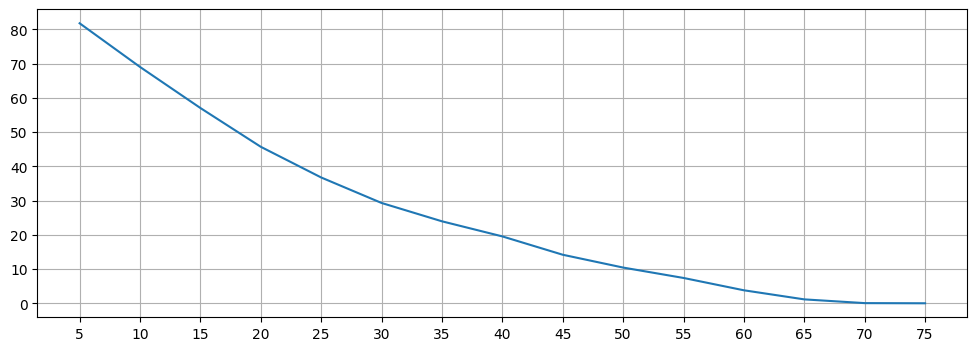

In [12]:
rolling_min_series = prices_df.groupby(prices_df.index.date)['low'].min().rolling(WINDOW_PERIOD).min()
period_close_series = prices_df.groupby(prices_df.index.date)['close'].last().shift(-WINDOW_PERIOD)
df = pandas.DataFrame({
    'daily_prices': daily_prices, 
    'period_close_series': period_close_series, 
    'rolling_min_series': rolling_min_series
})
df['rolling_min_series'] = df['rolling_min_series'].shift(-WINDOW_PERIOD)
df['drawdown_pct'] = -df['rolling_min_series'].divide(df['daily_prices']).subtract(1.).multiply(100.)
df['period_perf_pct'] = df['period_close_series'].divide(df['daily_prices']).subtract(1.).multiply(100.)
df.dropna(inplace=True)
df.index = pandas.to_datetime(df.index) 
frequencies = dict()
for loss in range(5, 80, 5):
    frequencies[loss] = 100. * df['drawdown_pct'][df['drawdown_pct'] > loss].count() / df['drawdown_pct'].count()

pandas.Series(frequencies, name='loss_distribution').plot(figsize=(12,4), grid=True, xticks=list(frequencies.keys()))

**Performance distribution**

<AxesSubplot: >

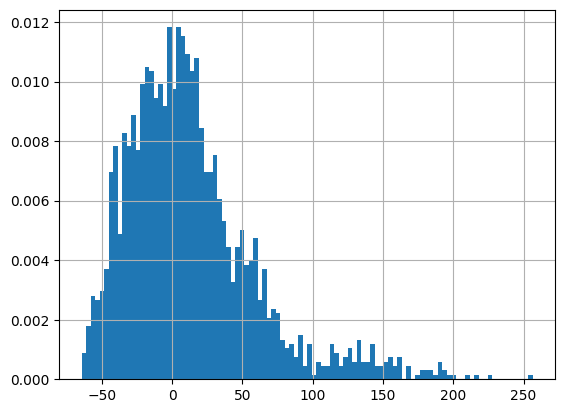

In [13]:
df['period_perf_pct'].hist(bins=100, density=True)

<AxesSubplot: >

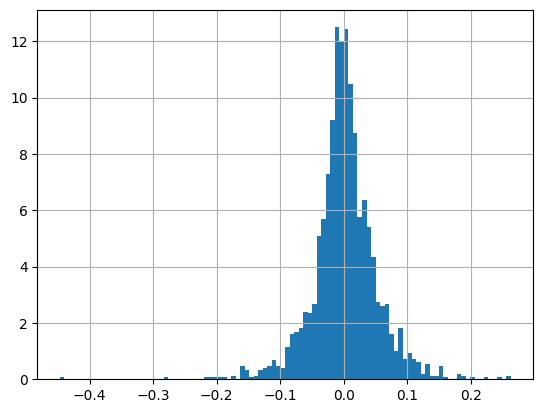

In [14]:
perf = df["daily_prices"].shift(-1).divide(df["daily_prices"]).subtract(1.).dropna()
perf.hist(bins=100, density=True)

## Option valuation model

<AxesSubplot: >

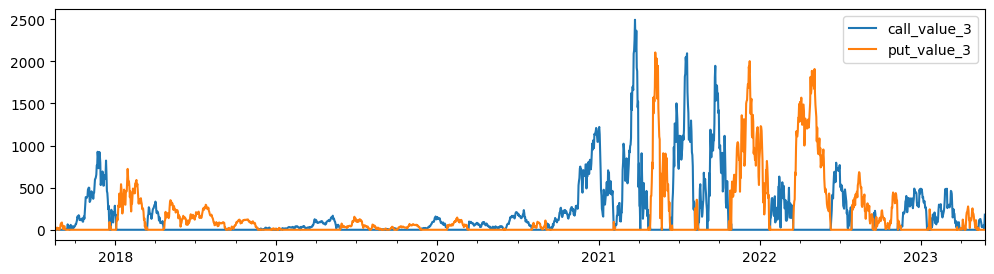

In [15]:
def generate_strikes(price: float):
    closest_hundred = round(price / 100.) * 100.
    strikes = set()
    strikes.add(closest_hundred)
    for i in range(1, 3):
        strikes.add(closest_hundred + i * 100.)
        strikes.add(closest_hundred - i * 100.)
        
    return strikes

strike_prices = list(generate_strikes(CURRENT_PRICE))
for count, strike_price in enumerate(strike_prices, start=1):
    strike_factor = strike_price / CURRENT_PRICE
    df[f'strike_{count}'] = df['daily_prices'].multiply(strike_factor)
    df[f'strike_pct_{count}'] = strike_factor
    
    df[f'call_value_{count}'] = df['period_close_series'].subtract(df[f'strike_{count}'])
    df[f'call_value_{count}'].loc[df[f'call_value_{count}'] < 0.] = 0.
    df[f'call_value_pct_{count}'] = df[f'call_value_{count}'].divide(df['daily_prices'])
    
    df[f'put_value_{count}'] = df[f'strike_{count}'].subtract(df['period_close_series'])
    df[f'put_value_{count}'].loc[df[f'put_value_{count}'] < 0.] = 0.
    df[f'put_value_pct_{count}'] = df[f'put_value_{count}'].divide(df['daily_prices'])
    

df[['call_value_3', 'put_value_3']].plot(figsize=(12,3))


In [16]:

option_chain = list()
for count, strike_price in enumerate(strike_prices, start=1):
    option_chain.append({
        'strike': strike_price,
        'value_call': df[f'call_value_pct_{count}'].mean() * CURRENT_PRICE,
        'value_put': df[f'put_value_pct_{count}'].mean() * CURRENT_PRICE,
        'value_call_median': df[f'call_value_pct_{count}'].quantile(0.5) * CURRENT_PRICE,
        'value_put_median': df[f'put_value_pct_{count}'].quantile(0.5) * CURRENT_PRICE
    })
    
pandas.DataFrame(option_chain).set_index('strike').sort_index()

,value_call,value_put,value_call_median,value_put_median
strike,,,,
1800.0,574.587054,138.165861,289.782864,0.000000
1900.0,511.766799,175.345606,189.782864,0.000000
2000.0,453.999355,217.578162,89.782864,0.000000
2100.0,401.786168,265.364975,0.000000,10.217136
2200.0,355.307747,318.886554,0.000000,110.217136


In [17]:
df.sample(1, random_state=42).transpose()

,2018-10-31
daily_prices,197.240000
period_close_series,100.390000
rolling_min_series,81.790000
drawdown_pct,58.532752
period_perf_pct,-49.102616
strike_1,178.677403
strike_pct_1,0.905888
call_value_1,0.000000
call_value_pct_1,0.000000
put_value_1,78.287403


<AxesSubplot: >

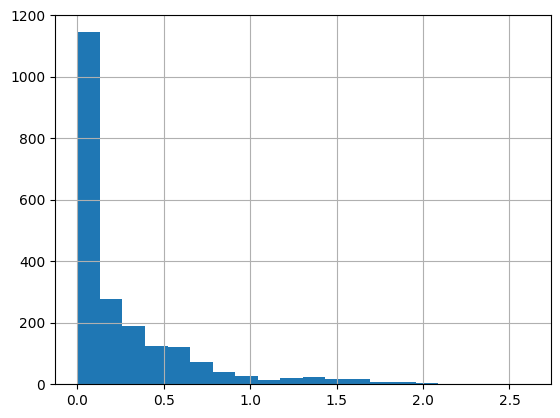

In [19]:
df[f'call_value_pct_2'].hist(bins=20)

In [20]:
df[f'call_value_pct_2'].describe()

count    2109.000000
mean        0.257558
std         0.385110
min         0.000000
25%         0.000000
50%         0.095512
75%         0.368466
max         2.608901
Name: call_value_pct_2, dtype: float64